In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import gc
import time
import warnings

from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from PIL import Image

from sklearn.model_selection import GridSearchCV

import string
import re    #for regex
#import spacy
import nltk
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer 

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split




start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
#eng_stopwords = set(stopwords.words("english"))
warnings.filterwarnings("ignore")

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

%matplotlib inline


In [2]:
train_df = pd.read_csv('C:/Users/Admin/Downloads/all/train.csv')
test_df = pd.read_csv('C:/Users/Admin/Downloads/all/test.csv')

In [3]:
cols_target = ['obscene','insult','toxic','severe_toxic','identity_hate','threat']

In [4]:
cols_target2=train_df[['obscene','insult','toxic','severe_toxic','identity_hate','threat']]

In [5]:
cols_target2.sum()

obscene           8449
insult            7877
toxic            15294
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64

In [6]:
cols_target2.sum()/len(cols_target2)

obscene          0.052948
insult           0.049364
toxic            0.095844
severe_toxic     0.009996
identity_hate    0.008805
threat           0.002996
dtype: float64

In [7]:
# check missing values in numeric columns
train_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
# check for any 'null' comment
no_comment = train_df[train_df['comment_text'].isnull()]
len(no_comment)

0

In [9]:
# Let's look at the character length for the rows in the training data and record these
train_df['char_length'] = train_df['comment_text'].apply(lambda x: len(str(x)))

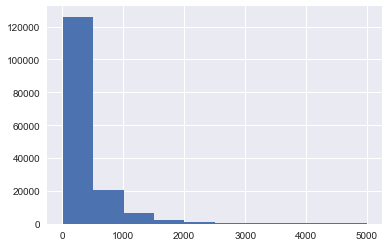

In [10]:
# look at the histogram plot for text length
sns.set()
train_df['char_length'].hist()
plt.show()

### Cleaning up the comment text

In [11]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [12]:
# clean the comment_text in train_df [Thanks to Pulkit Jha for the useful pointer.]
train_df['comment_text'] = train_df['comment_text'].map(lambda com : clean_text(com))

In [13]:
#clean the comment_text in test_df 
test_df['comment_text'] = test_df['comment_text'].map(lambda com : clean_text(com))

In [14]:
train_df = train_df.drop('char_length',axis=1)

In [15]:
X = train_df.comment_text
test_X = test_df.comment_text

In [16]:
# import and instantiate TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(max_features=5000,stop_words='english')
vect

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=5000, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [17]:
# learn the vocabulary in the training data, then use it to create a document-term matrix
X_dtm = vect.fit_transform(X)
# examine the document-term matrix created from X_train
X_dtm

<159571x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 3178792 stored elements in Compressed Sparse Row format>

In [18]:
# transform the test data using the earlier fitted vocabulary, into a document-term matrix
test_X_dtm = vect.transform(test_X)
# examine the document-term matrix from X_test
test_X_dtm

<153164x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 2618972 stored elements in Compressed Sparse Row format>

In [19]:
### building a multi-label classifier using Logistic Regression
# import and instantiate the Logistic Regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score




In [25]:
logreg = LogisticRegression(C=12.0)
for label in cols_target:
    print('... Processing {}'.format(label))
    y = train_df[label]    
    logreg.fit(X_dtm, y)
   
    y_pred_X = logreg.predict(X_dtm)
    print('Training accuracy is {}'.format(accuracy_score(y, y_pred_X)))


... Processing obscene
Training accuracy is 0.9832300355327722
... Processing insult
Training accuracy is 0.9755469352200588
... Processing toxic
Training accuracy is 0.9639846839337975
... Processing severe_toxic
Training accuracy is 0.9920724943755445
... Processing identity_hate
Training accuracy is 0.9939713356436947
... Processing threat
Training accuracy is 0.9981199591404453


In [26]:
#WITH l1
logreg =LogisticRegression(C=12,penalty='l1',tol=0.01)
for label in cols_target:
    print('... Processing {}'.format(label))
    y = train_df[label]    
    logreg.fit(X_dtm, y)   
    y_pred_X = logreg.predict(X_dtm)
    print('Training accuracy is {}'.format(accuracy_score(y, y_pred_X)))

... Processing obscene
Training accuracy is 0.9842264571883362
... Processing insult
Training accuracy is 0.976518289664162
... Processing toxic
Training accuracy is 0.9645048285716076
... Processing severe_toxic
Training accuracy is 0.9927681094935796
... Processing identity_hate
Training accuracy is 0.9948925556648764
... Processing threat
Training accuracy is 0.998828107864211


In [23]:
#with l2
logreg =LogisticRegression(C=12,penalty='l2',tol=0.01)
for label in cols_target:
    print('... Processing {}'.format(label))
    y = train_df[label]    
    logreg.fit(X_dtm, y)   
    y_pred_X = logreg.predict(X_dtm)
    print('Training accuracy is {}'.format(accuracy_score(y, y_pred_X)))

... Processing obscene
Training accuracy is 0.9828540273608614
... Processing insult
Training accuracy is 0.9750330573851138
... Processing toxic
Training accuracy is 0.9624681176404234
... Processing severe_toxic
Training accuracy is 0.9920098263468926
... Processing identity_hate
Training accuracy is 0.9938836004035821
... Processing threat
Training accuracy is 0.9981136923375802
